In [1]:
import pandas as pd


In [2]:
# Load Csv file
df = pd.read_csv('/content/oil_price.csv')


In [3]:
# Preview the data
df.head()

,Date,Price
0,"Jul 01, 2020",42.18
1,"Jul 02, 2020",43.19
2,"Jul 03, 2020",42.92
3,"Jul 06, 2020",42.73
4,"Jul 07, 2020",43.28


CLEAN AND PLOT THE DATA

In [4]:
import matplotlib.pyplot as plt

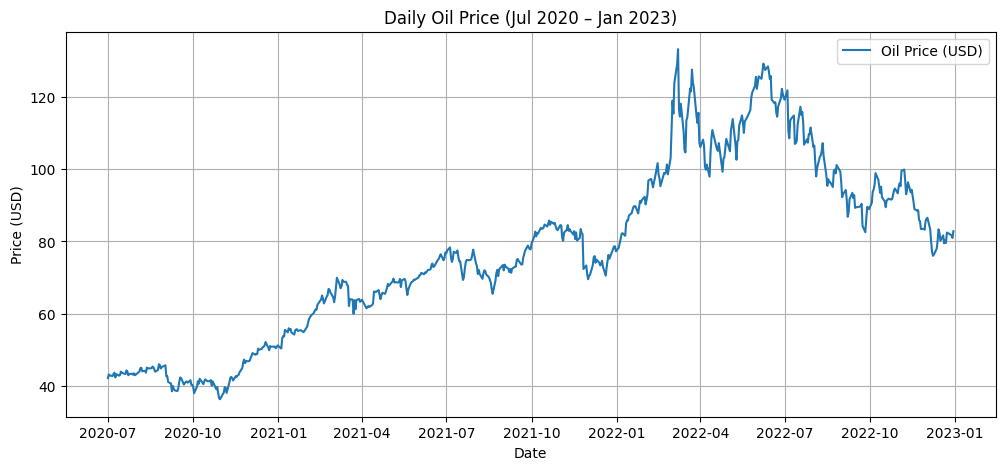

In [5]:
# Keep only non-empty rows
df = df.dropna()

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date just in case
df = df.sort_values('Date')

# Set the date as index for time series operations
df.set_index('Date', inplace=True)

# Plot the oil price time series
plt.figure(figsize=(12, 5))
plt.plot(df['Price'], label='Oil Price (USD)')
plt.title('Daily Oil Price (Jul 2020 – Jan 2023)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

ADF TEST

In [6]:
from statsmodels.tsa.stattools import adfuller

# ADF Test to check stationarity
result = adfuller(df['Price'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print(" The series is likely stationary (reject H0).")
else:
    print(" The series is likely non-stationary (fail to reject H0).")


ADF Statistic: -1.598608589550151
p-value: 0.48429238915100054
 The series is likely non-stationary (fail to reject H0).


ACF PLOT

<Figure size 1000x400 with 0 Axes>

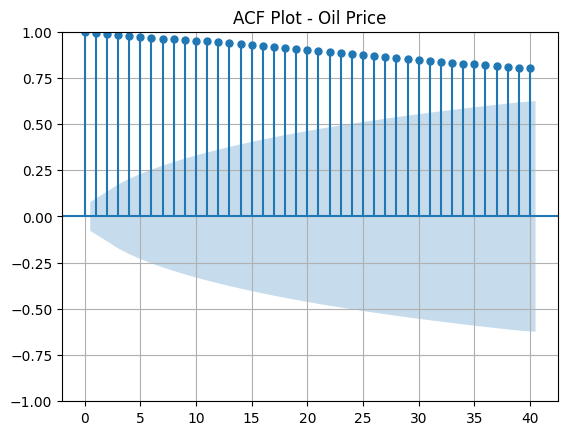

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# ACF plot
plt.figure(figsize=(10, 4))
plot_acf(df['Price'], lags=40)
plt.title('ACF Plot - Oil Price')
plt.grid(True)
plt.show()


LOG + FIRST DIFFERENCE

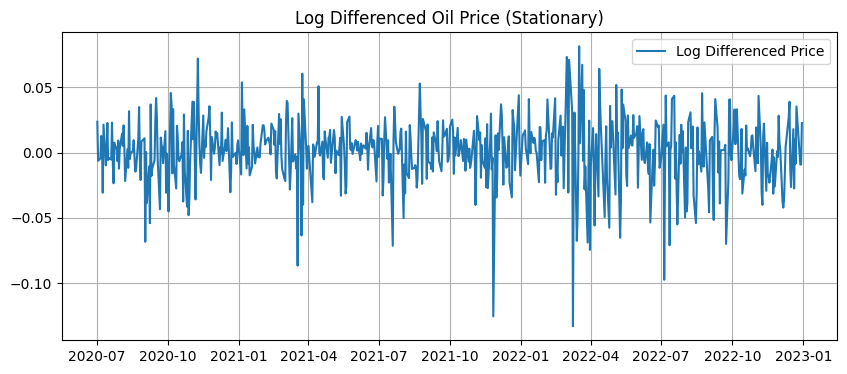

In [8]:
import numpy as np

# Apply log transformation
df['Log_Price'] = np.log(df['Price'])

# First differencing (log returns)
df['LogDiff'] = df['Log_Price'].diff()

# Drop NA after differencing
df_diff = df.dropna()

# Plot differenced series
plt.figure(figsize=(10, 4))
plt.plot(df_diff['LogDiff'], label='Log Differenced Price')
plt.title('Log Differenced Oil Price (Stationary)')
plt.grid(True)
plt.legend()
plt.show()


ADF TEST AGAIN ON DIFFERENCED DATA

In [9]:
# ADF Test on log-differenced data
result = adfuller(df_diff['LogDiff'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print(" Now the series is likely stationary (reject H0).")
else:
    print(" Still non-stationary (unlikely but check plot).")


ADF Statistic: -12.212595838346747
p-value: 1.1546685084664035e-22
 Now the series is likely stationary (reject H0).


PLOAT PACF TO CHOOSE P

<Figure size 1000x400 with 0 Axes>

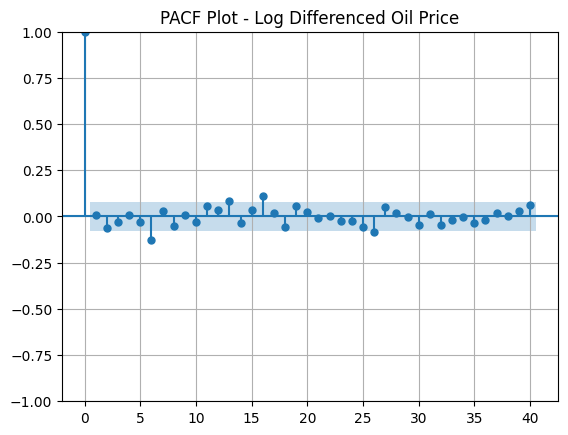

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

# PACF plot to choose AR (p)
plt.figure(figsize=(10, 4))
plot_pacf(df_diff['LogDiff'], lags=40, method='ywm')
plt.title('PACF Plot - Log Differenced Oil Price')
plt.grid(True)
plt.show()


GRID SEARCH FOR ARIMA

In [11]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

warnings.filterwarnings("ignore")

# Define range
p_values = range(0, 9)
d_values = range(0, 3)
q_values = range(0, 9)


best_aic = np.inf
best_order = None

# Grid search
for d in d_values:
    for p in p_values:
        for q in q_values:
            try:
                model = ARIMA(df['Log_Price'], order=(p, d, q))
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, d, q)
            except:
                continue


print("Best ARIMA(p,d,q):", best_order)
print("Best AIC:", best_aic)


Best ARIMA(p,d,q): (1, 1, 6)
Best AIC: -2870.857334276122


FIT THE MONTH AND FORECAST 24 MONTHS

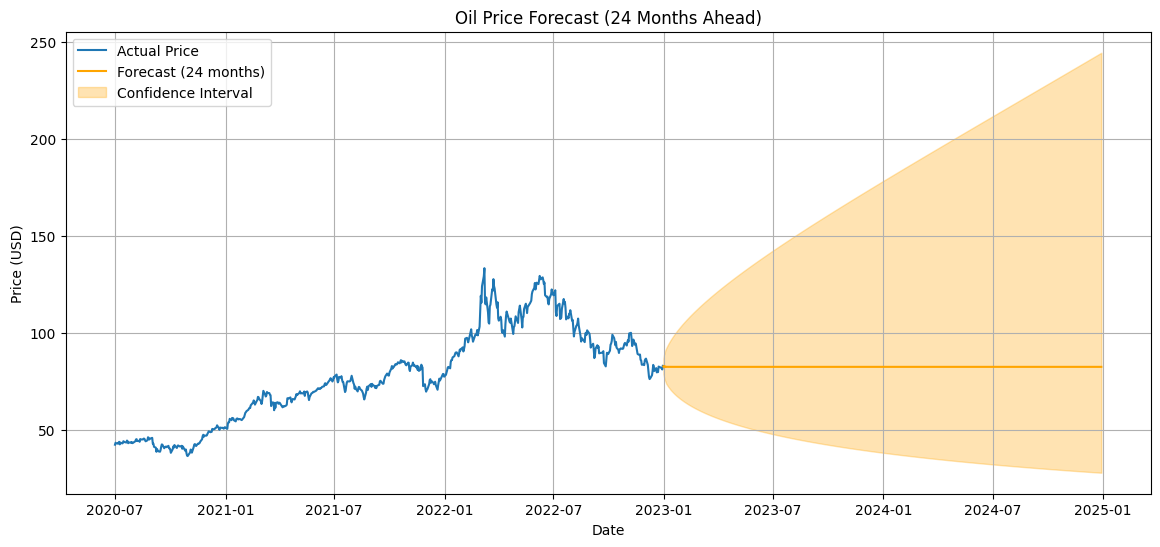

In [12]:
# Refit best model
best_model = ARIMA(df['Log_Price'], order=(1, 1, 6))
fitted_model = best_model.fit()

# Forecast next 730 days (24 months)
forecast = fitted_model.get_forecast(steps=730)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Convert forecast back from log to original price scale
forecast_original = np.exp(forecast_mean)
conf_int_exp = np.exp(conf_int)

# STEP: Fix forecast date range
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=730)
forecast_original.index = forecast_dates
conf_int_exp.index = forecast_dates

# Plot actual and forecasted values
plt.figure(figsize=(14, 6))
plt.plot(df['Price'], label='Actual Price')
plt.plot(forecast_original, label='Forecast (24 months)', color='orange')
plt.fill_between(forecast_original.index,
                 conf_int_exp.iloc[:, 0],
                 conf_int_exp.iloc[:, 1],
                 color='orange', alpha=0.3, label='Confidence Interval')
plt.title("Oil Price Forecast (24 Months Ahead)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


RMSE EVALUATION FROM FITTED VALUES

In [13]:
from sklearn.metrics import mean_squared_error

predicted_log = fitted_model.fittedvalues
actual_log = df['Log_Price'].dropna()
rmse = np.sqrt(mean_squared_error(actual_log, predicted_log))
print("RMSE:", rmse)


RMSE: 0.15055296889846329


COMPARISON WITH REAL TIME DATA

[*********************100%***********************]  1 of 1 completed


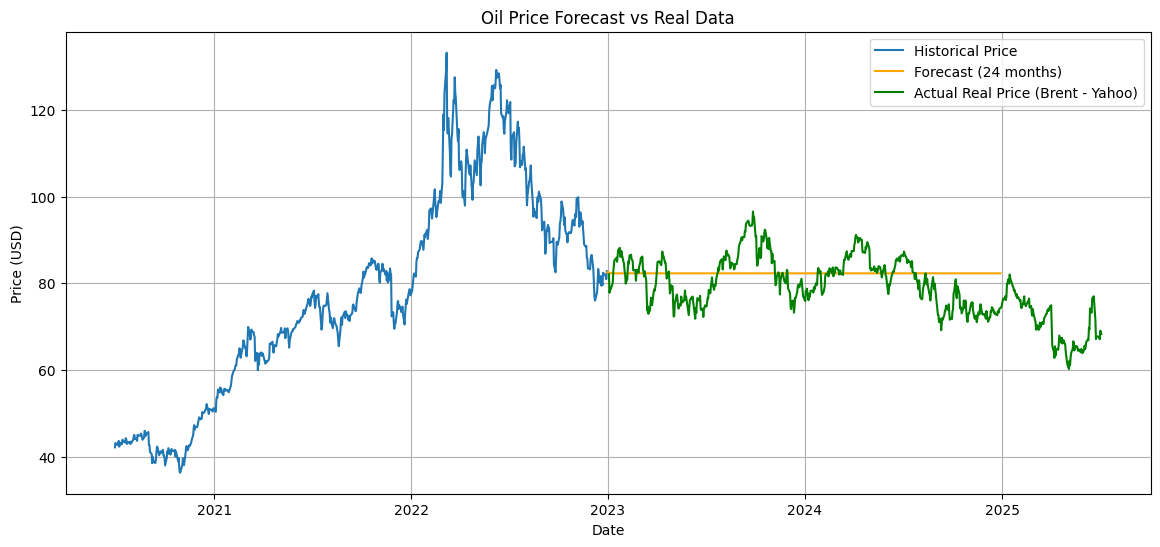

In [14]:
!pip install yfinance --quiet

import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

# Download oil prices from Jan 2023 to today
real_oil = yf.download('BZ=F', start='2023-01-01', end=datetime.today().strftime('%Y-%m-%d'))

# Keep only the closing price and rename
real_oil = real_oil[['Close']]
real_oil.rename(columns={'Close': 'Real Price'}, inplace=True)

# Plot historical, forecast, and real oil prices
plt.figure(figsize=(14,6))
plt.plot(df['Price'], label='Historical Price')  # original training data
plt.plot(forecast_dates, forecast_original, label='Forecast (24 months)', color='orange')
plt.plot(real_oil.index, real_oil['Real Price'], label='Actual Real Price (Brent - Yahoo)', color='green')

plt.title("Oil Price Forecast vs Real Data")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()



FORECASTING OIL PRICE USING LSTM - ALTERNATIVE MODEL

In [15]:
# Preprocess data for LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os

# Set random seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Use only 'Price' column
data = df[['Price']].copy()
scaler = MinMaxScaler()
data['Scaled'] = scaler.fit_transform(data)

# Create sequences for LSTM 60-day lookback
lookback = 60
X, y = [], []
for i in range(lookback, len(data)):
    X.append(data['Scaled'].values[i - lookback:i])
    y.append(data['Scaled'].values[i])

X, y = np.array(X), np.array(y)
# reshape to 3D for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

BUILT AND TRAIN MODEL

In [16]:
# Build and train LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[es], verbose=1)



Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - loss: 0.1781 - val_loss: 0.0222
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0090 - val_loss: 0.0018
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0022 - val_loss: 0.0032


PREDICTION AND PLOTING

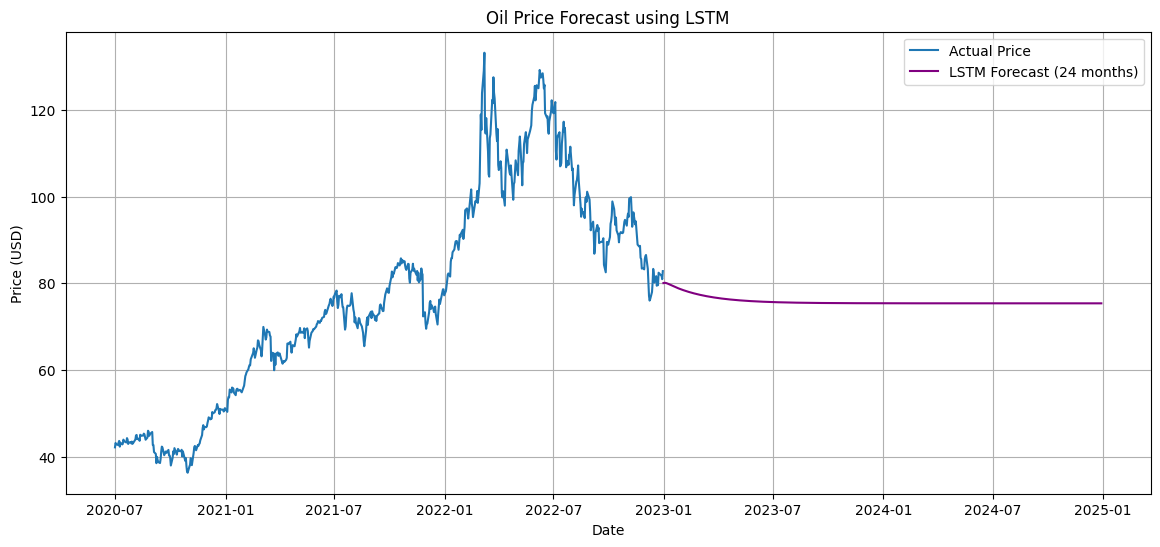

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 
LSTM RMSE: 4.145002835209042


In [17]:
# Forecast next 730 days (24 months)
forecast_input = data['Scaled'].values[-lookback:].reshape(1, lookback, 1)
forecast_scaled = []

for _ in range(730):
    pred = model.predict(forecast_input, verbose=0)
    forecast_scaled.append(pred[0, 0])
    forecast_input = np.append(forecast_input[:, 1:, :], [[pred[0]]], axis=1)

# Inverse transform to original price
forecast_lstm = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Create forecast dates and plot
forecast_dates_lstm = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=730)

plt.figure(figsize=(14, 6))
plt.plot(df['Price'], label='Actual Price')
plt.plot(forecast_dates_lstm, forecast_lstm, label='LSTM Forecast (24 months)', color='purple')
plt.title("Oil Price Forecast using LSTM")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on test set
y_pred_test = model.predict(X_test)
y_pred_actual = scaler.inverse_transform(y_pred_test)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print("LSTM RMSE:", lstm_rmse)



COMPARE WITH REAL DATA

[*********************100%***********************]  1 of 1 completed


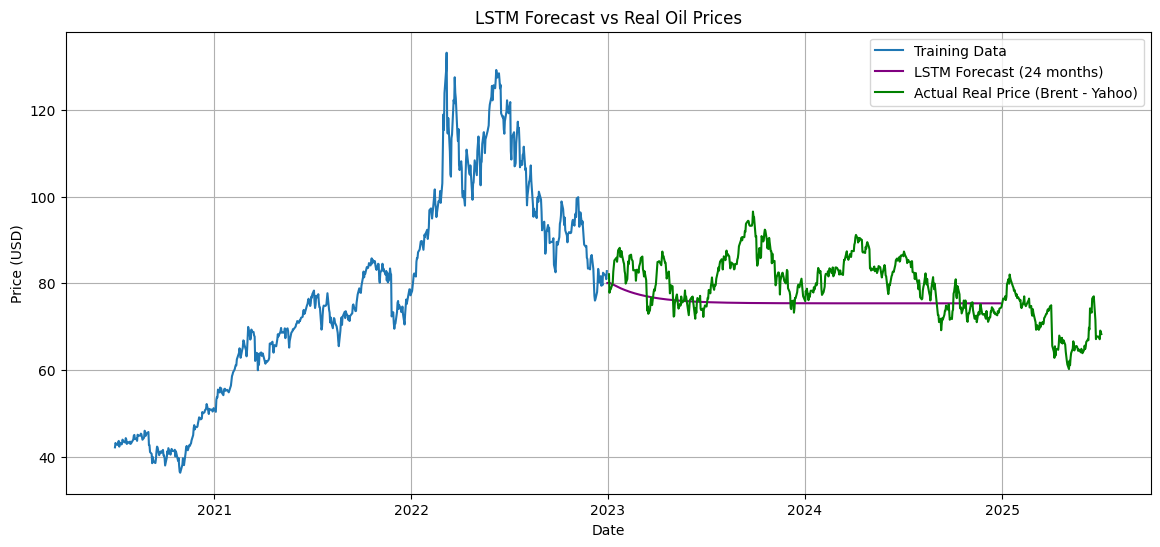

In [18]:
# Install and import dependencies
!pip install yfinance --quiet

import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

# Download Brent crude oil prices from Jan 2023 to today
real_oil = yf.download('BZ=F', start='2023-01-01', end=datetime.today().strftime('%Y-%m-%d'))

# Keep only closing prices and rename column
real_oil = real_oil[['Close']]
real_oil.rename(columns={'Close': 'Real Price'}, inplace=True)

# Plot historical, LSTM forecast, and real Brent prices
plt.figure(figsize=(14, 6))
plt.plot(df['Price'], label='Training Data')
plt.plot(forecast_dates_lstm, forecast_lstm, label='LSTM Forecast (24 months)', color='purple')
plt.plot(real_oil.index, real_oil['Real Price'], label='Actual Real Price (Brent - Yahoo)', color='green')

plt.title("LSTM Forecast vs Real Oil Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

